Задание:
> Implement simple processing pipeline:
> 
> Run/use any broker of your choice
> 
> Create minimal producer and consumer
>
> Run several producers and several consumer simultaneously

Попробую сделать очередь для микросервисного взаимодействия такую, что продьюсер ожидает ответа от консьюмера (request/reply модель). Ответ нужен или сейчас (допустим, в течение 5 секунд), или никогда. Раз так, то можно рассчитывать на то, что персистентность не потребуются - поэтому попробую NATS Core (не JetStream), в котором гарантий персистентности (доступности сообщений после сбоев, перезапусков) нет

```sh
curl -sf https://binaries.nats.dev/nats-io/nats-server/v2@latest | sh
sudo mv nats-server /usr/bin/
```

In [4]:
!nats-server -v

nats-server: v2.11.6


In [7]:
!nats-server

[15337] 2025/07/12 18:38:39.763402 [INF] Starting nats-server
[15337] 2025/07/12 18:38:39.763455 [INF]   Version:  2.11.6
[15337] 2025/07/12 18:38:39.763459 [INF]   Git:      [bc813ee]
[15337] 2025/07/12 18:38:39.763461 [INF]   Name:     NBZT7LE7YE3FGIDMGVG255T2VEQLQKPS23SPJUGKIGYNSGPV4ONRARR6
[15337] 2025/07/12 18:38:39.763476 [INF]   ID:       NBZT7LE7YE3FGIDMGVG255T2VEQLQKPS23SPJUGKIGYNSGPV4ONRARR6
[15337] 2025/07/12 18:38:39.763925 [INF] Listening for client connections on 0.0.0.0:4222
[15337] 2025/07/12 18:38:39.764130 [INF] Server is ready
^C
[15337] 2025/07/12 18:38:42.000241 [INF] Trapped "interrupt" signal
[15337] 2025/07/12 18:38:42.000531 [INF] Initiating Shutdown...
[15337] 2025/07/12 18:38:42.000691 [INF] Server Exiting..


Что делаю в начале:
1. Если активных консьюмеров нет, продьюсер спит 10 секунд и пишет об этом в лог
2. Между новыми сообщениями от продьюсера проходит не более секунды. Консьюмер обрабатывает одну задачу от двух до трёх секунд.
3. Отправленная в очередь задача актуальна на протяжении пяти секунд. Затем корутина, назначенная на обработку ответа, падает по таймауту

Опубликовать можно даже в несуществующий subject. Но если я публикую по схеме request-reply, то NATS ожидает, что есть хотя бы один активный консьюмер, который подписан на subject и готов ответить. Если я публикую по схеме publish-subscribe в несуществующий subject, в NATS Core оно просто никому не достанется и канет в лету

Код, приведённый ниже - это первоначальные версии без дальнейших доработок. Окончательные версии - в соседних файлах.

## Продьюсер 
#### producer.py

In [213]:
import nats
import json
import random
from datetime import datetime
import asyncio
from asyncio import create_task, Event, sleep, run
from nats.errors import NoRespondersError, TimeoutError
from misc import SUBJECT, URL, get_logger


async def get_request(nc, message, no_consumers_event, logger):
    user_id = message['user_id']
    try:
        response = await nc.request(
            SUBJECT, 
            json.dumps(message).encode(),
            timeout=5, 
            headers=dict(user_id=str(user_id)))
        logger.info(f'Got response for {user_id=}')
    except NoRespondersError:
        no_consumers_event.set()
    except TimeoutError:
        logger.error(f'Timeout for {user_id=}')


async def main():
    nc = await nats.connect(URL)
    no_consumers_event = Event()
    logger = get_logger('producer')
    users_bank = cycle(range(1000))
    try:
        while True:
            if no_consumers_event.is_set():
                logger.warning('No consumers available. Falling asleep')
                await sleep(10)
                no_consumers_event.clear()
            user_id = next(users_bank)
            message = {"user_id": user_id}
            create_task(get_request(nc, message, no_consumers_event, logger))
            await asyncio.sleep(random.uniform(0, 1.5))
    finally:
        await nc.close()

if __name__ == '__main__':
    run(main())

## Консьюмер
#### consumer.py

In [ ]:
import nats
import json
import random
import asyncio
from asyncio import run
from misc import SUBJECT, URL, get_logger


async def main():
    nc = await nats.connect(URL)
    sub = await nc.subscribe(SUBJECT, queue="workers")
    logger = get_logger('consumer')
    logger.info('Start consuming')
    async for msg in sub.messages:
        data = json.loads(msg.data.decode())
        logger.info(f"Got msg with user_id={msg.headers['user_id']} queued at {data['ts']}")
        response = {'proceeded': True, **data}
        await asyncio.sleep(random.uniform(2, 2.4))
        await msg.respond(json.dumps(response).encode())


if __name__ == '__main__':
    run(main())

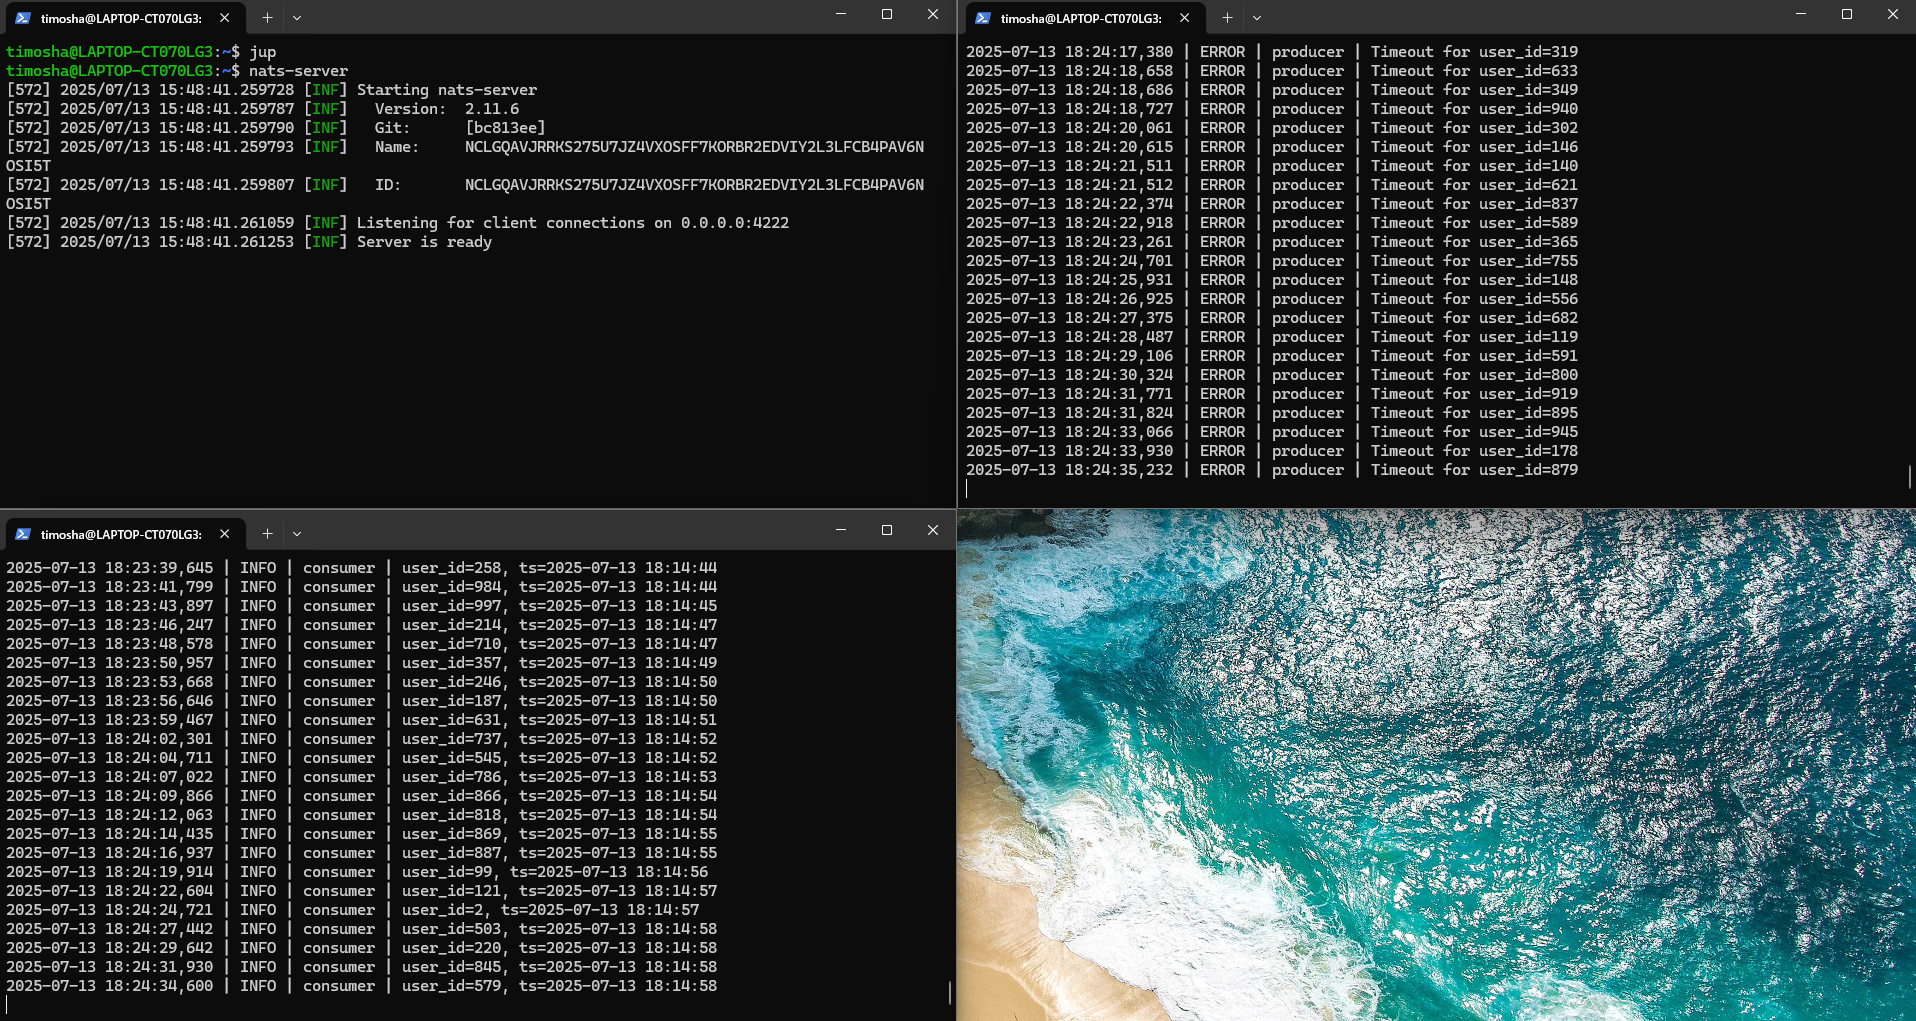

Выявил такие проблемы:
1. Если консьюмер только подключился, то он не получит задач, возникших до его подключения. 
2. Но вот затем все сообщения, адресованные ему, к нему попадут - даже если на стороне продьюсера уже давно случился таймаут и никто не ждёт ответа. Из-за этого скапливается очередь, хотя держать за собой хвост длиннее 5 секунд нет смысла

Что можно предложить:
1. Очередь не персистента и не хранит сообщения. Если нет подписчиков, сообщение просто "теряется" (не доставляется никому), и это не считается ошибкой в NATS Core. C этим ничего не поделаешь
2. Несколько улучшений:
    1. Хочу логгировать информацию о том, сколько консьюмеру адресовано сообщений (сколько не разобрано).
    2. Хочу удалять сообщения из очереди, если оно не взято в обработку в течение 5 секунд после появления, либо на стороне консьюмера скипать по ts старые сообщения без обработки. Первое звучит лучше, второе - если первое не выйдет
    3. Если консьюмер может скипать сообщения по ts, не заглядывая в тело, то пусть ts будет в заголовках, а не в теле - тело может быть затратно декодировать.

1. Эта информация ассоциирована с подпиской. У каждого консьюмера на стороне NATS есть буфер, в котором лежат сообщения, которые адресованы ему, но ещё не извлчены и не обработаны. Добавляю в код `sub.pending_msgs`
2. Выяснил, что зависшие сообщения уже доставлены сервером NATS конкретному подписчику (моему консьюмеру). Они находятся в "буфере клиентской библиотеки", то есть в памяти воркера. Если так, то не имеет смысла пытаться удалить сообщение из очереди - его уже в ней нет. Надо отматывать на стороне консьюмера
3. Сделал

И запустил ещё одного консьюмера, который обрабатывает сообщения быстрее, чем они появляются. Теоретически, он один мог бы справиться со всеми задачами

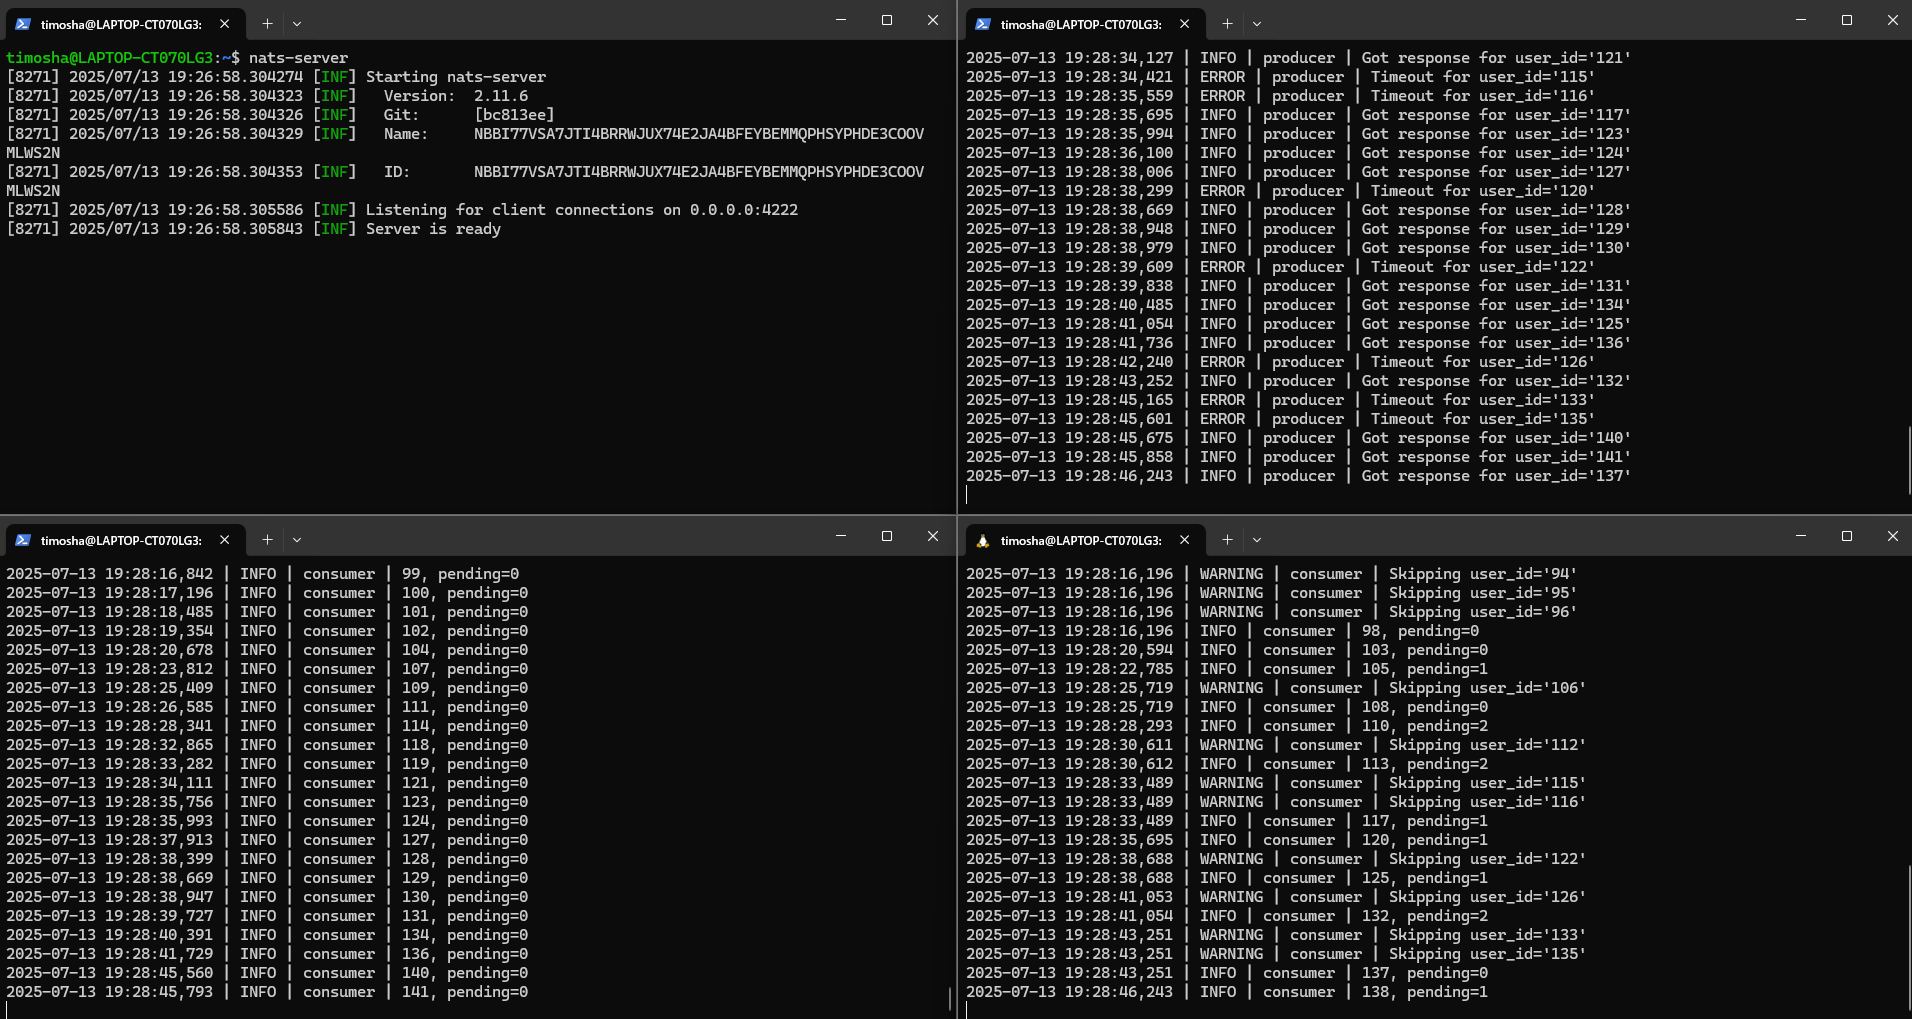

Но NATS распределяет сообщения по умолчанию, используя round-robin алгоритм. Первый консьюмер получает столько же, сколько второй, однако часть полученных сообщений не успевает обработать до таймаута.

Варианты решения:
1. Изменить push-модель на pull-модель
2. Изменить round-robin на что-то, основанное на статистике
3. Запретить брокеру кидать консьюмеру в буфер новое сообщение, пока не обработано предыдущее. Пусть держит у себя
4. Запретить продьюсеру кидать новое сообщение в брокера, пока нет ack-ов на предыдущие

Нюансы:
1. pull-модель работает только в JetStream
2. В NATS Core нет встроенной поддержки кастомных алгоритмов балансировки. Можно было бы сделать отдельный топик для каждого рабочего воркера и публикать там текущий latency, а продьюсер бы кидал сообщения в топик к самому свободному воркеру и сам реализовывал логику балансировки. Но выглядит слишком запутанно и требует publish/subsribe модели. request/reply можно сделать, если оставить одного консьюмера, который будет балансировать поступающие сообщения между остальными воркерами. Но это ещё запутаннее
3. А это, кажется, вполне возможно. Добавляю `pending_msgs_limit=1` в настройку подключения консьюмера
4. Технически возможно, но хочется сохранить асинхронность во взаимодействии продьюсера с консьюмером

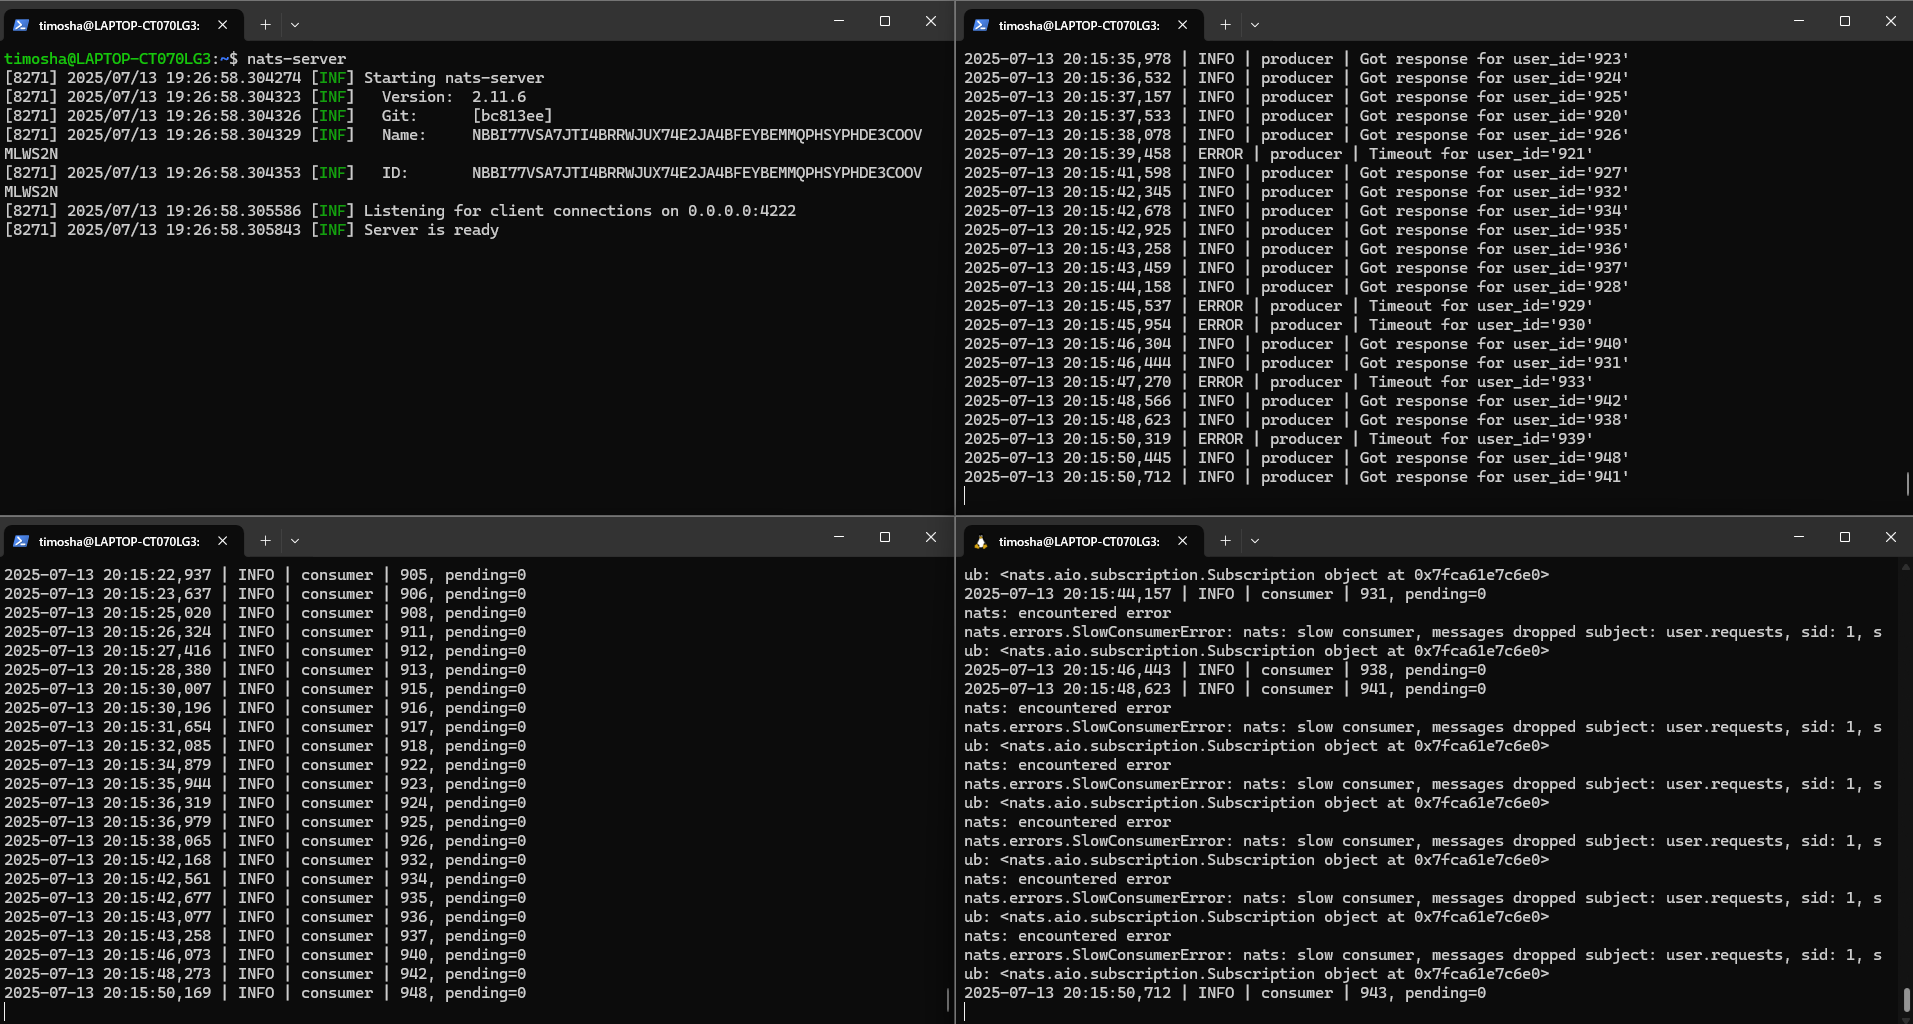

Брокер продолжает пушить сообщения, но теперь консьюмер отказывается их принимать, если он занят предыдущими сообщениями. Сообщение в этом случае теряется - NATS не передаёт его следующему консьюмеру, а выкидывает. Так что размером буфера такие проблемы не решаются. Буферизация, видимо, помогает консьюмеру подгружать новые сообщения в фоне, но не помогает брокеру с балансировкой. 

Если нам всё-таки нужно что-то сделать с медленным консьюмером, можем воспользоваться буфером как инструментом: копим в буфере столько, сколько консьюмер обработает за 4 секунды. Когда буфер достигает такого размера, который обработается за 4 секунды, консьюмер отписывается от топика и разбирает накопившиеся сообщения. Затем снова подписывается.

Стопаю медленного консьюмера - все сообщения из сабжекта теперь адресуются быстрому. Гарантия доставки в NATS Core - at least once. Брокер не следит за ack-ами, поэтому сообщения, доставленные медленному консьюмеру - потеряны.

Разведу двух консьюмеров по разным консьюмер-группам чтобы посмотреть, что будет.

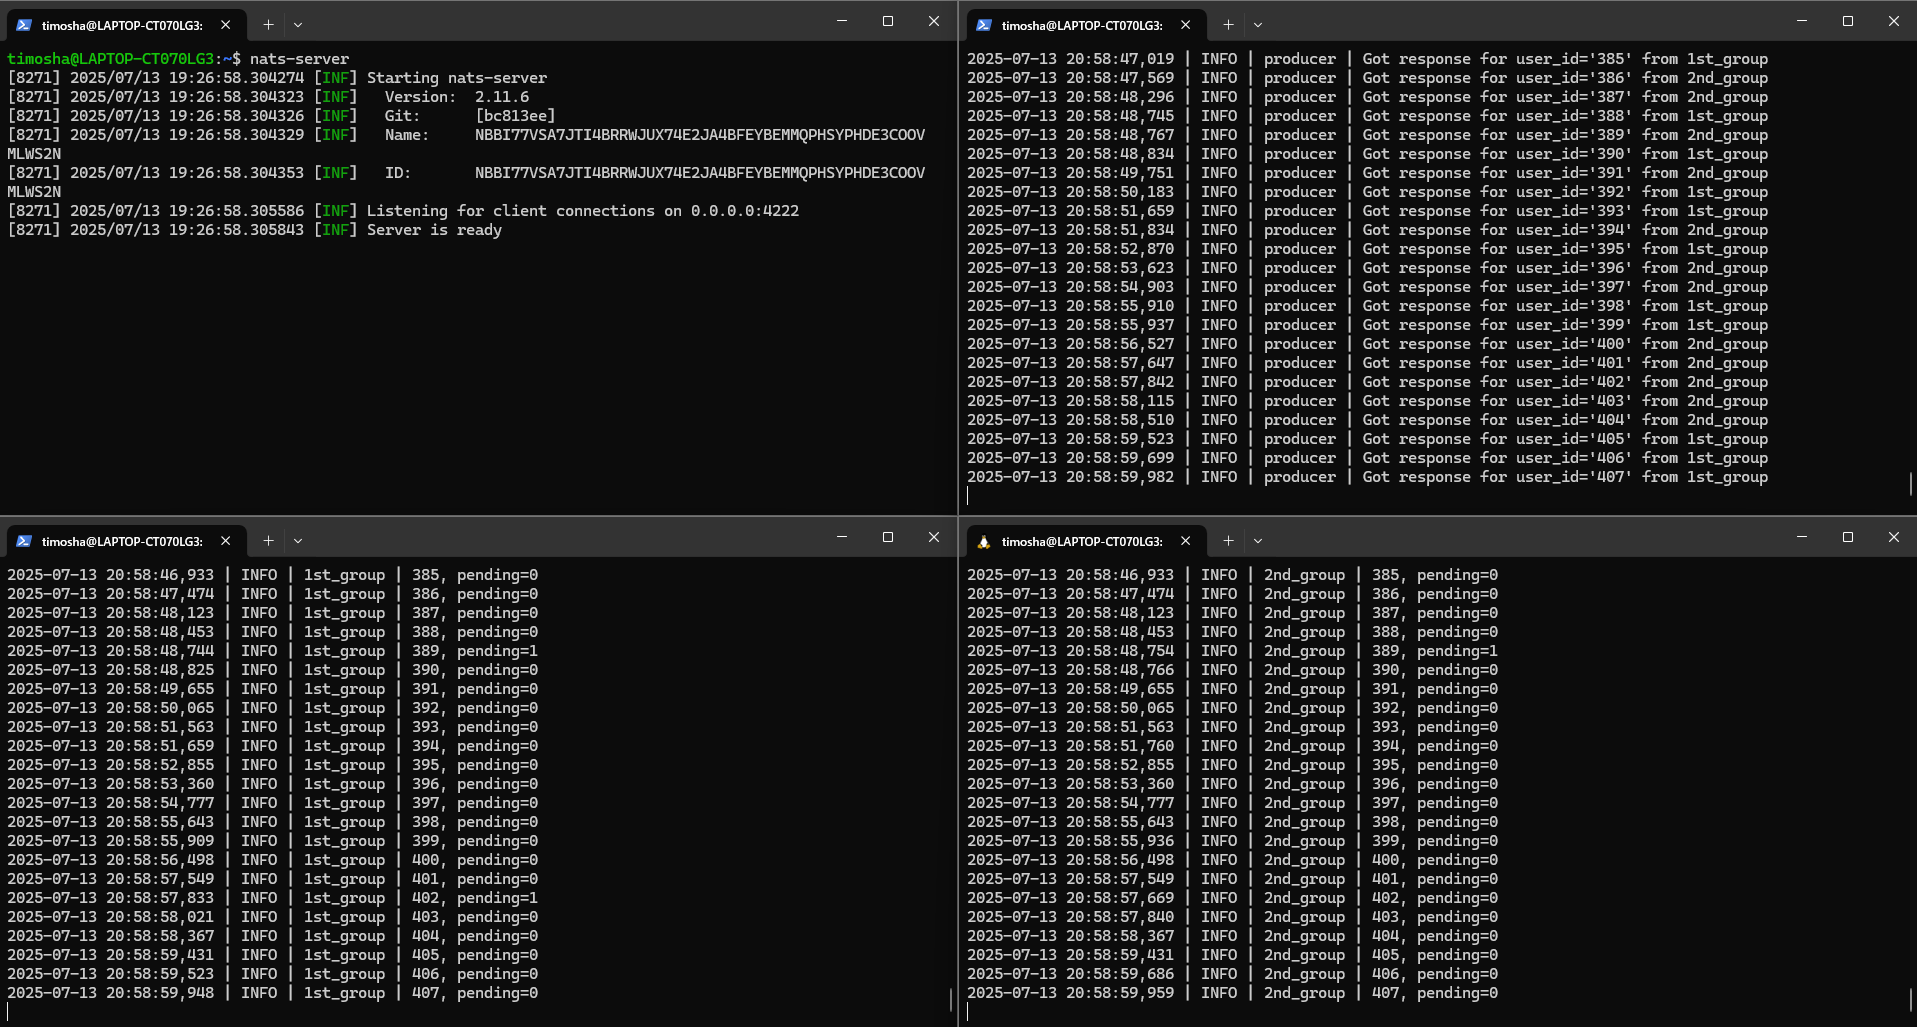

В каждую группу попадёт 100% поступивших сообщений, но только первый ответ будет доставлен продьюсеру. Впрочем, ошибок в запоздавших группах не будет - reply-и отработают, хотя запоздавшие ответы никому не достанутся. 

Если один subject заполняют два продьюсера, то, в целом, ничего не меняется

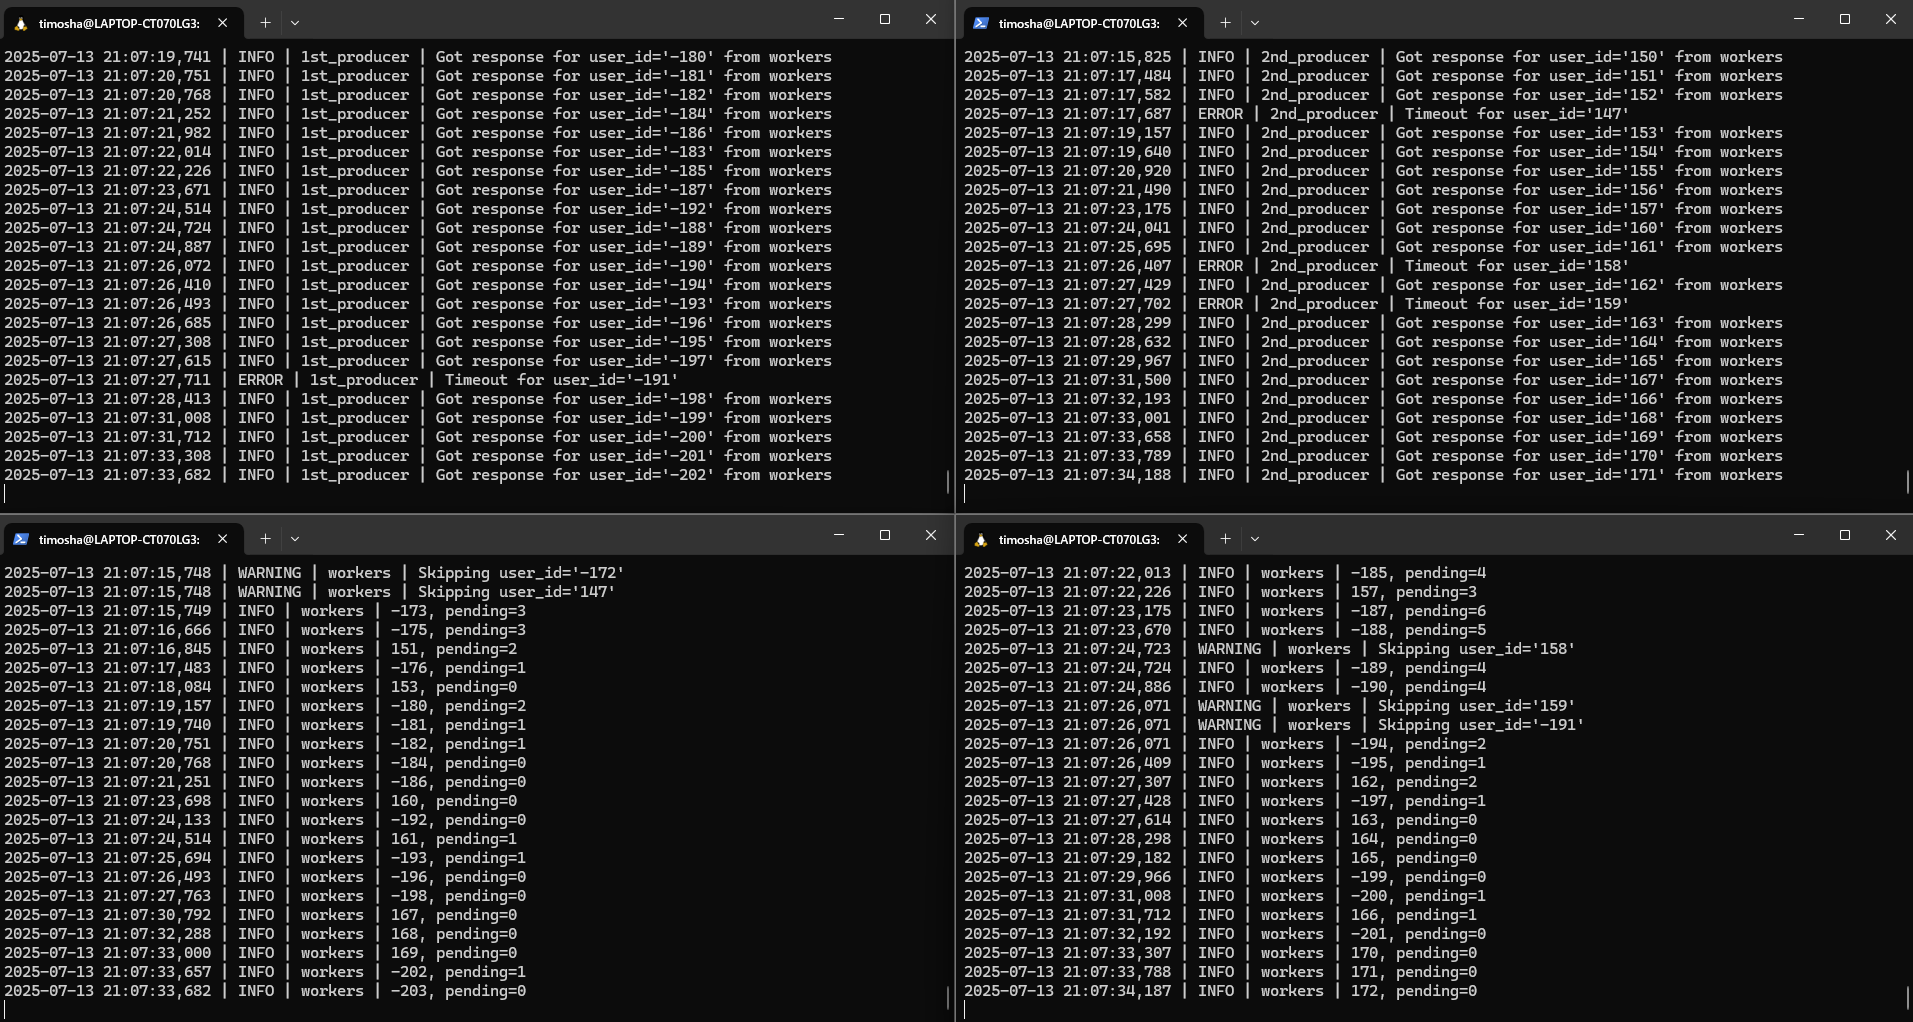

* Если потушить брокера, то потеряются сообщения, на которые уже запрошен ответ, но ещё не получен.
* Если потушить консьюмера, то вместе с ним пропадут сообщения, взятые им в обработку (включая буфер).
* Если потушить продьюсера, то, в целом, ничего не теряется, но если какие-то сообщения упавшего продьюсера ожидают ответа, то ответ пропадёт. Второй продьюсер не примет на себя ответ, направленный другому.

Если хоть что-то из этого критично, то, наверное, лучше экспериментировать с JetStream. NATS Core работает по принципу fire-and-forget и отказывается организовывать хранение сообщений на стороне брокера. А это необходимо, если нужно подстраховаться от потери сообщений консьюмером или продьюсером